In [1]:
import math
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import json
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from IPython.display import Image, display
from IPython.display import Image, display
import keras

In [2]:
%cd /content/drive/MyDrive/cnn_embed/cnn_manifold

/content/drive/MyDrive/cnn_embed/cnn_manifold


In [3]:
# TODO proper reception field size
# TODO image initiation does not work for inception deeper layers
# TODO optimization steps

In [3]:
layer_name = "conv3_block4_out"
model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)
#layer_name = "mixed3"
#model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False)
layer = model.get_layer(name=layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)


94674944/94668760 [==============================] - 1s 0us/step


In [4]:
def initialize_image(img_size):
    # We start from a gray image with some random noise
    img = tf.Variable(tf.random.normal([1, img_size, img_size, 3], 0, 0.01, tf.float32, seed=1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    return img

def compute_loss(img, direction, activation_model, img_size=180, cos_sim=False, x=None, y=None):
    #TODO: batch
    acts = activation_model(img) 
    # visualize the neuron in the center of each layer
    shape = tf.shape(acts)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    filter_activation = acts[0, 2:-2, 2:-2, :]
    # TODO: cosine similarity
    if cos_sim==False:
        loss = -tf.reduce_mean(filter_activation*direction)
    return loss
def gradient_ascent_step(img, direction, activation_model, learning_rate, opt):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, direction, activation_model)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    opt.apply_gradients(zip([grads], [img]))
    loss = compute_loss(img, direction, activation_model)
    return loss, img
def visualize_filter(img, direction, activation_model, img_size=180, learning_rate=0.1, n_iter=100):
    
    # gradient ascent
    #img = initialize_image(img_size)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(n_iter):
        loss, img = gradient_ascent_step(img, direction, activation_model, learning_rate, opt)
        # Progress
        if (i % 100 == 0):
            print(f'i = {i}')
    # Decode the resulting input image
    processed_img = deprocess_image(img[0].numpy())
    return loss, img, processed_img
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [16]:
img_size = 180


In [20]:
direction0 = np.random.random((1, 512))

<tf.Variable 'Variable:0' shape=(1, 180, 180, 3) dtype=float32, numpy=
array([[[[  60.481895 ,   79.4284   ,   82.62404  ],
         [ 103.80321  ,  128.34006  ,  114.33652  ],
         [ -88.69637  , -115.08167  ,  -88.3094   ],
         ...,
         [  44.41873  ,   98.12285  ,   21.046003 ],
         [ -28.127249 ,    4.7190795,  -28.162651 ],
         [ -60.875145 ,  -52.506805 ,  -44.10144  ]],

        [[  55.452114 ,  102.138275 ,  117.90779  ],
         [ 121.20077  ,  140.18887  ,  116.01153  ],
         [ 186.88599  ,  184.53392  ,  175.68611  ],
         ...,
         [ 100.818054 ,  139.58855  ,   67.474495 ],
         [ 106.3454   ,  138.05772  ,   83.491394 ],
         [ -17.08319  ,   52.010925 ,   14.503121 ]],

        [[-120.007256 , -105.58993  ,  -16.27238  ],
         [-123.075905 , -141.29126  , -109.22439  ],
         [  87.695206 ,   36.575134 ,  108.664154 ],
         ...,
         [  32.507942 ,   87.19681  ,  -77.43479  ],
         [ 129.3728   ,  151.05539 

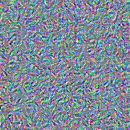

In [21]:
img = initialize_image(img_size)
loss, img, processed_img = visualize_filter(img, direction, activation_model, n_iter=4, learning_rate=100)

In [ ]:
keras.preprocessing.image.save_img("0.png", processed_img)
display(Image("0.png"))

In [61]:
# TODO tf.function
def compute_loss(input_image, direction_index, activation_model):
    activation = activation_model(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, direction_index]
    return -tf.reduce_mean(filter_activation)

def initialize_image(img_size):
    # We start from a gray image with some random noise
    img = tf.Variable(tf.random.normal([1, img_size, img_size, 3], 0, 0.01, tf.float32, seed=1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    return img


def gradient_ascent_step_Adam(img, direction_index, activation_model, learning_rate, opt):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, direction_index, activation_model)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    opt.apply_gradients(zip([grads], [img]))
    loss = compute_loss(img, direction_index, activation_model)
    return loss, img

def visualize_filter_Adam(img, direction_index, activation_model, img_size=180, learning_rate=0.1, n_iter=100):
    # gradient ascent
    #img = initialize_image(img_size)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(n_iter):
        loss, img = gradient_ascent_step_Adam(img, direction_index, activation_model, learning_rate, opt)
        # Progress
        if (i % 100 == 0):
            print(i)
    # Decode the resulting input image
    processed_img = deprocess_image(img[0].numpy())
    return loss, img, processed_img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))